<a href="https://colab.research.google.com/github/vlozg/aicovid/blob/main/%5BTorch008_base%5D_AICOVID_115M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thí nghiệm trước mình đã cho chạy được với data final, đồng thời cũng có thêm các việc khác như:
- Tìm hiểu về AUC và AUROC (về cơ bản AUC chỉ là chỉ **phương thức** tính diện tích dưới đường curve, chứ không phải là 1 loại metric, AUC-ROC mới là một loại metric khi curve ở đây là ROC).
- Hoàn thiện được quá trình inference để submit và đạt 0.77 trên leaderboard (tuy nhiên giải pháp này có vẻ không robust khi đem so với data warmup thì messed-up vkl).
- Đọc 1 số paper để hiểu thêm về vấn đề với bài toán âm thanh/tín hiệu số.
- Khám phá ra rằng metrics không messed-up lắm khi test trên data variable length (wow...).

Các vấn đề tồn đọng cho tới hiện tại:
- Chunking khiến lượng data bùng nổ.
- Tinh chỉnh lại code để hoạt động được với lightning 1.4.0

Trong notebook này, trọng tâm mình sẽ cố gắng thử nhiều cách khác nhau để bắt đầu đua leaderboard (hy vọng vậy...).

Các ý tưởng có thể thử:
- Transformer.
- Multi-task learning.

exp000: thử multi-task learning, không cho resnet chứa fc ở trong nữa và thử oversampling --> 0.79

exp001: thử binary covid task --> 0.789

exp002 - exp004: thử nghiệm với batch size, learning rate, grad accumulate và undersampling

exp005: thử normalize chuẩn (tức lấy mean/std theo toàn dataset chứ không theo từng sample)
- Theo AST sẽ lấy mean/std từng sample rồi lấy mean/std tổng bằng mean của đống đó. --> 0.792
- Theo mình nên làm kỹ hơn như sau: tương tự như trên nhưng lấy theo từng freq band.

Đoạn code giúp tránh việc bị shutdown notebook do inactive.
```javascript
function prevent_timeout(){
document
.querySelector('#top-toolbar > colab-connect-button')
    .shadowRoot.querySelector('#connect').click()
}

setInterval(prevent_timeout, 60000)
```

In [ ]:
#@title Cài các thư viện bổ sung.
#@markdown (note: cài xong phải restart runtime nếu tính dùng tensorboard hay tensorflow gì đó do pl downgrade tensorboard...)

#@markdown Các thư viện bổ sung bao gồm:
#@markdown - PyDrive2 (để upload file có kích thước lớn lên GDrive)
#@markdown - torchaudio
#@markdown - Pytorch Lightning
#@markdown - Neptune client (để tạo logger coi online, tránh phải ngồi canh và backup thủ công khi dùng tensor board)

try:
  import torchaudio
except ImportError:
  !pip install PyDrive2
  !pip install torchaudio
  !pip install pytorch-lightning==1.3.8
  !pip install 'neptune-client[pytorch-lightning]'
  # exit()

     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 3.2 MB 12.2 MB/s 
     |████████████████████████████████| 1.9 MB 9.0 MB/s 
     |████████████████████████████████| 813 kB 8.0 MB/s 
     |████████████████████████████████| 118 kB 64.6 MB/s 
     |████████████████████████████████| 5.6 MB 50.1 MB/s 
     |████████████████████████████████| 272 kB 71.0 MB/s 
     |████████████████████████████████| 829 kB 71.1 MB/s 
     |████████████████████████████████| 636 kB 54.7 MB/s 
     |████████████████████████████████| 1.3 MB 55.6 MB/s 
     |████████████████████████████████| 294 kB 60.1 MB/s 
     |████████████████████████████████| 142 kB 65.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=04ec4c7b360edb863ca42505c0b70f8c828fe74ee584dc1c84c19effa2613ab9
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall:

In [ ]:
#@title Lấy xác thực google để upload/download file
#@markdown Vui lòng bấm vào link khi được yêu cầu và lấy mã để nhập vào

# Xác thực google để upload/download qua google drive
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

class GDrive():
    def __init__(self):
        self._gauth = GoogleAuth()
        self._gauth.credentials = self._get_creds()
        self._drive = GoogleDrive(self._gauth)

    def _get_creds(self):
        auth.authenticate_user()
        return GoogleCredentials.get_application_default()

    def Refresh_Auth(self):
        self._gauth.credentials = self._get_creds()

    def SearchInFolder(self, parent_id, file_name):
        self.Refresh_Auth()
        return self._drive.ListFile({'q': f"'{parent_id}' in parents and title = '{file_name}'"}).GetList()

    def CreateFile(self, file_name=None, parent_id=None):
        self.Refresh_Auth()
        file = self._drive.CreateFile({'title': file_name, 
                                       'parents': [{'id': parent_id}]})
        return file

    def Upload(self, file_path, parent_id, file_name=None):
        if file_name == None:
          file_name = file_path.split('/')[-1]
        # Kiểm tra file tồn tại
        file_list = self.SearchInFolder(parent_id, file_name)
        if len(file_list) > 1:
          for file in file_list:
            print('title: %s, id: %s' % (file['title'], file['id']))
          raise NameError('More than 1 file with same name exist, please resolve this')
        
        elif len(file_list) == 0:
          # File chưa có thì tạo mới
          file = self.CreateFile(file_name, parent_id)
        else:
          # Tồn tại duy nhất 1 file
          file = file_list[0]
        
        file.SetContentFile(file_path)
        file.Upload()

    def Download(self, file_name, parent_id):
        # Kiểm tra file tồn tại
        file_list = self.SearchInFolder(parent_id, file_name)
        if len(file_list) > 1:
            for file in file_list:
                print('title: %s, id: %s' % (file['title'], file['id']))
            raise NameError('More than 1 file with same name exist, please resolve this')
        elif len(file_list) == 0:
            raise NameError(f'File named {file_name} not exist')
        else:
            # Tồn tại duy nhất 1 file
            file = file_list[0]
        
        file.GetContentFile(file_name)

drive = GDrive()

In [ ]:
from getpass import getpass

#@title Nhập Neptune API token
api_token = getpass('Enter your private Neptune API token: ')

Enter your private Neptune API token: ··········


# Detect COVID-19 patients via forced-cough cell phone recording

- **Bài toán**: Nhận diện người nhiễm COVID-19 qua tiếng ho ép buộc
    - **Input**: Đoạn ghi âm tiếng ho, tuổi và giới tính
    - **Output**: Phân loại người nhiễm bệnh hay không

## Tìm hiểu bài toán 
Qua paper (https://dspace.mit.edu/bitstream/handle/1721.1/128954/09208795.pdf?sequence=1&isAllowed=y)

## Đọc papers
[1] Kranthi Kumar Lella and Alphonse Pja (2021), *Automatic diagnosis of COVID-19 disease using deep convolutional neural network with multi-feature channel from respiratory sound data: Cough, voice, and breath*, access via: https://www.sciencedirect.com/science/article/pii/S1110016821003859

- Nguồn tham khảo tốt cho các paper có liên quan làm cùng chủ đề.
- Chỉ ra các paper trước đó không thành công lắm.
> From all these background work senses, there is **no accurate model** for diagnosing COVID-19 disease symptom
- Chỉ ra rằng hầu hết các dataset bị redundancy (1 speaker tạo nhiều mẫu).
- Dùng 4 loại augment: time stretch, shift pitch, dynamic range (nôm na là cân bằng volume), background noise inject.
- Dùng 3 channel: DAE (remove background noise), GFCC (short respiratory feature) và IMFCC (rich respiratory feature) -> Model có thực sự dùng hết cả 3 channel?
- Phần nói về implement hơi messed up (text mô tả kiến trúc 1 đường hình minh họa một nẻo?).

# Các biến thiết lập cho thử nghiệm

In [ ]:
# Nếu muốn train mô hình thì set thành True
experiment_id = '008' #@param {type:"string"}
val_split = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}

In [ ]:
# ID của folder lưu model trên drive
model_zoo = 'secret'
# ID của folder chứa submission
submission_folder = 'secret'
# Tên của file nén để nộp
zip_name = f'Torch_ver{experiment_id}'
# ID của folder chứa data đã preprocess
datadump_folder = 'secret'

# Setup
Import thư viện, tải data, đọc data, tạo helper function,...

## Import thư viện

In [ ]:
# Quản lý file, folder
import os

# Xử lý audio
import torchaudio

# Hiện audio nghe thử
import IPython.display as ipd
from IPython.display import Audio, display
from tqdm import tqdm

import random
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, WeightedRandomSampler, Sampler

import pytorch_lightning as pl

pl.utilities.seed.seed_everything(seed=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Global seed set to 1


device(type='cuda')

## Dataset class

In [ ]:
#@markdown ## Các hàm vỏ bọc cho đọc file
#@markdown `read_audio(path)`: vỏ bọc cho `torchaudio.load(path)`.<br>
#@markdown `read_resample_audio(path)`: chỉ trả về wave vì sample rate đã được cố định.

'''
  Read audio from given path and return (wave, sample_rate)
'''
def read_audio(full_audio_path):
  return torchaudio.load(full_audio_path)

'''
  Read audio from given path, then resample if sample rate is not matched 
  and return wave.

  Tips: 
    you should provide resampler from torchaudio.transform
    when batch resampling with same params since this can
    give a huge speed up.
'''
def read_resample_audio(
    full_audio_path, resample,
    resampler=None
):
  wave, sr = torchaudio.load(full_audio_path)
  if resampler is not None:
      wave = resampler(wave)
  elif sr != resample:
      wave = torchaudio.functional.resample(wave, sr, resample)
  return wave

In [ ]:
class AudioChunking(torch.nn.Module):
    def __init__(self,
                 chunk_size: int=400,
                 chunk_step: int=200,
                 idx_instead: bool=False) -> None:
        super(AudioChunking, self).__init__()
        self.chunk_size = chunk_size
        self.chunk_step = chunk_step
        self.idx_instead = idx_instead
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        spec_len = spec.shape[-1]
        pad_size = self.chunk_size - spec_len%self.chunk_size
        pad_size = (pad_size//2, pad_size//2+pad_size%2)
        padded_spec = torch.nn.functional.pad(spec, pad_size, mode='constant', value=0)
        
        if self.idx_instead:
            spec_len = padded_spec.shape[-1]
            chunk_idxs = [(i, i+self.chunk_size-1) for i in range(0,spec_len-self.chunk_size+1,self.chunk_step)]
            return padded_spec, chunk_idxs
        else:
            chunks = padded_spec.unfold(-1, self.chunk_size, self.chunk_step).permute(2,0,1,3)
            return chunks

In [ ]:
## check_integrity.py
from typing import Optional, Any
import hashlib
import os

def calculate_md5(fpath: str, chunk_size: int = 1024 * 1024) -> str:
    md5 = hashlib.md5()
    with open(fpath, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''):
            md5.update(chunk)
    return md5.hexdigest()


def check_md5(fpath: str, md5: str, **kwargs: Any) -> bool:
    return md5 == calculate_md5(fpath, **kwargs)


def check_integrity(fpath: str, md5: Optional[str] = None) -> bool:
    if not os.path.isfile(fpath):
        return False
    if md5 is None:
        return True
    return check_md5(fpath, md5)

In [ ]:
from urllib.parse import urlparse
from typing import Optional
import re

def _get_google_drive_file_id(url: str) -> Optional[str]:
    # Src: pytorch/vision/utils
    parts = urlparse(url)

    if re.match(r"(drive|docs)[.]google[.]com", parts.netloc) is None:
        return None

    match = re.match(r"/file/d/(?P<id>[^/]*)", parts.path)
    if match is None:
        return None

    return match.group("id")

In [ ]:
#@markdown `StandardScaler(mean, std)`
class StandardScaler(nn.Module):
    def __init__(self, mean=None, std=None) -> None:
        super(StandardScaler, self).__init__()
        
        # Set property for query, can't change inner scaler if change these value
        self.mean = mean
        self.std = std

        if mean is None:
            if std is None:
                  self.scaler = lambda spec: (spec-spec.mean)/spec.std
            else:
                  self.scaler = lambda spec: (spec-spec.mean)/std
        elif std is None:
            self.scaler = lambda spec: (spec-mean)/spec.std
        else:
            self.scaler = lambda spec: (spec-mean)/std
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return self.scaler(spec).nan_to_num(posinf=0.0, neginf=0.0)

#@markdown `MinMaxScaler(min, max)`
class MinMaxScaler(nn.Module):
    def __init__(self, min=None, max=None) -> None:
        super(MinMaxScaler, self).__init__()
        if min:
            self._min = lambda x: min
        else:
            self._min = lambda x: x.min()
        if max:
            self._max = lambda x: max
        else:
            self._max = lambda x: x.max()
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return ((spec-self._min(spec))/(self._max(spec)-self._min(spec))).nan_to_num(posinf=0.0, neginf=0.0)

In [ ]:
from torch.utils.data import Dataset
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from tqdm import tqdm
import tempfile, shutil
import weakref
import pickle
import warnings
import ast

from sklearn.model_selection import train_test_split


class AICOVIDDataset(Dataset):
    '''
    AICOVID dataset made easy
    '''

    available_splits = ["w_pub_train", "w_pub_test", "w_pri_test", "f_pub_train", "f_pub_test", "f_pri_test"]

    official_urls = {
        "w_pub_train": "https://drive.google.com/file/d/1MPhz3zYl2yefCq-J5XySbFJt99BfKIZD/view",
        "w_pub_test": "https://drive.google.com/file/d/1UrMudzopA3CyR1Ih2J63Kfi2mY_0uhRK/view",
        "w_pri_test": "https://drive.google.com/file/d/1hP8rHwJ_bz3J1T4MtEEp53ZBe9fdFKrW/view",
        "f_pub_train": "https://drive.google.com/file/d/1Oq9UgA9cEGMNRGvF7oNKkFOg6udsDprl/view",
        "f_pub_test": "https://drive.google.com/file/d/159SghfGeqVj3AfgTRZXsAAAj0-3ogccX/view",
        "f_pri_test": None
    }

    mirrored_urls = {
        "w_pub_train": "https://drive.google.com/file/d/1hoGLxjLmPY-pX-jSVGIaWIZhovQBMKU1/view",
        "w_pub_test": "https://drive.google.com/file/d/1X7vOjHos9f9w48-iTWyu5JElFqCjcH_R/view",
        "w_pri_test": "https://drive.google.com/file/d/1Ec64sSm2dZqe3da_LVyE_jUBD0DnLyqB/view",
        "f_pub_train": "https://drive.google.com/file/d/1HoRJllAfYNeBPoCz2nXkf7lQ3raPcFYf/view",
        "f_pub_test": "https://drive.google.com/file/d/1w5N5prH-uWqLvoSZnuY8TIqm_BBgN2ND/view",
        "f_pri_test": None
    }

    resources = {
        "w_pub_train": ("aicv115m_public_train.zip", None),
        "w_pub_test": ("aicv115m_public_test.zip", None),
        "w_pri_test": ("aicv115m_private_test.zip", None),
        "f_pub_train": ("aicv115m_final_public_train.zip", None),
        "f_pub_test": ("aicv115m_final_public_test.zip", None),
        "f_pri_test": None
    }

    audio_paths = {
        "w_pub_train": 'aicv115m_public_train/train_audio_files_8k/',
        "w_pub_test": 'aicv115m_public_test/public_test_audio_files_8k/',
        "w_pri_test": 'aicv115m_private_test/private_test_audio_files_8k/',
        "f_pub_train": 'aicv115m_final_public_train/public_train_audio_files/',
        "f_pub_test": 'aicv115m_final_public_test/public_test_audio_files/',
        "f_pri_test": None
    }

    ############
    #   init
    ############

    def __init__(self, 
                 split: Optional[str]=None,
                 audio_transforms: Optional[nn.ModuleList]=None, 
                 normalize: Optional[Union[str, nn.Module]]=None,
                 chunking: Optional[Tuple[int, int]]=None,
                 val_split: Optional[bool]=None,
                 split_ratio: float=0.8,
                 cleanup_after: bool=True) -> None:
        
        # Dataset statistic: mean, std, mean by freq band, std by freq band
        if split is None: return  # Allow empty dataset for loading from gdrive later

        if split not in self.available_splits:
            raise NameError(f"{split} is not a valid split, please check again!")

        self.split = split
        self.download()

        self.meta_df = self.extract_archive()

        if val_split is not None:
            idx_train, idx_val = train_test_split(self.meta_df.index, train_size=split_ratio, random_state=1)
            self.meta_df = self.meta_df.iloc[idx_val if val_split else idx_train]

        # Create temporary folder to dump preprocessed data
        self._temp_folder = tempfile.mkdtemp()
        self._finalizer = weakref.finalize(self, shutil.rmtree, self._temp_folder)

        self.file_paths = []
        self.idxs = []
        self.chunk_idxs = None
        
        self.mean = []
        self.std = []
  
        self.process_files(audio_transforms, chunking, normalize)

        if normalize == 'ast':
            self.scaler = StandardScaler(self.mean, self.std)
        elif normalize == 'by_freq_band':
            self.mean = torch.tensor(self.mean).unsqueeze(-1)
            self.std = torch.tensor(self.std).unsqueeze(-1)
            self.scaler = StandardScaler(self.mean, self.std)
        elif isinstance(normalize, StandardScaler):
            self.scaler = normalize
            self.mean = normalize.mean
            self.std = normalize.std
        elif normalize is None:
            self.scaler = lambda x: x
            print("This dataset is not normalized, be careful!")
        else:
            raise KeyError("Invalid 'normalize' value")

        self.normalize_dataset()
        
        if cleanup_after:
            self.cleanup_extract()


    ################################
    #   download/extract/cleanup
    ################################

    def _check_exists(self) -> bool:
        return check_integrity(*self.resources[self.split])


    def download(self) -> None:
        if self._check_exists():
            print("> Archive have already downloaded")
            return
        file_id = _get_google_drive_file_id(self.official_urls[self.split])
        os.system(f"gdown --id {file_id}")
        print("\n> Archive download complete")


    def extract_archive(self) -> pd.DataFrame:
        file_name, _ = self.resources[self.split]
        os.system(f"unzip -n -q {file_name}")
        print("\n> Extract complete")

        # split standardize (some split have different folder organize style)
        if self.split == "w_pub_train":
            os.system("unzip -n -q aicv115m_public_train/train_audio_files_8k.zip -d ./aicv115m_public_train")
            meta = pd.read_csv('aicv115m_public_train/metadata_train_challenge.csv').drop(columns=["file_path"])
        elif self.split == "w_pub_test":
            os.system("unzip -n -q aicv115m_public_test/public_test_audio_files_8k.zip -d /aicv115m_public_test")
            meta = pd.read_csv('aicv115m_public_test/metadata_public_test.csv').drop(columns=["file_path"])
        elif self.split == "w_pri_test":
            meta = pd.read_csv('aicv115m_private_test/metadata_private_test.csv').drop(columns=["file_path"])
        elif self.split == "f_pub_train":
            meta = pd.read_csv('aicv115m_final_public_train/public_train_metadata.csv')
            med_meta = pd.read_csv("aicv115m_final_public_train/public_train_medical_condition.csv")
            meta = meta.merge(med_meta, how="left", on="uuid")
            meta = self._process_final_meta(meta)
        elif self.split == "f_pub_test":
            meta = pd.read_csv('aicv115m_final_public_test/public_test_sample_submission.csv').drop(columns=["assessment_result"])
        elif self.split == "f_pri_test":
            raise NotImplementedError()

        return meta


    def _process_final_meta(self, meta):
        # Convert string in list/dict format to real list/dict object
        str_to_obj = lambda x: ast.literal_eval(x)
        col_tobe_processed = ['cough_intervals', 'symptoms_status_choice', 'medical_condition_choice',]
        for col in col_tobe_processed:
            meta[col] = meta[col].map(str_to_obj, na_action='ignore')

        # Process list type columns and categorical columns
        medical_condition_choice_df = pd.get_dummies(meta['medical_condition_choice'].apply(pd.Series).stack()).sum(level=0)
        medical_condition_choice_df = medical_condition_choice_df.drop(columns=['No'])
        symptoms_status_choice_df = pd.get_dummies(meta['symptoms_status_choice'].apply(pd.Series).stack()).sum(level=0)
        symptoms_status_choice_df = symptoms_status_choice_df.drop(columns=['No'])
        sex_dummies = pd.get_dummies(meta['subject_gender'])
        meta = meta.join([sex_dummies, medical_condition_choice_df, symptoms_status_choice_df])
        meta.drop(columns=['subject_gender', 'symptoms_status_choice','medical_condition_choice'], inplace=True)

        # Convert to ordinal values
        age_map = {'group_0_2': 1, 
                  'group_3_5': 2,
                  'group_6_13': 3,
                  'group_14_18': 4,
                  'group_19_33': 5,
                  'group_34_48': 6,
                  'group_49_64': 7,
                  'group_65_78': 8,
                  'group_79_98': 9
                  }

        smoke_map = {
            'never': 0,
            'ex': 1,
            'ltOnce': 2,
            '1to10': 3,
            '11to20': 4,
            '21+': 5,
            'ecig': 6
        }

        insomnia_map = {
            'No': 0,
            'Onceper2Weeks': 1,
            '2to3': 2,
            '1': 3,
            '4+': 4
        }

        meta = meta.replace({'subject_age': age_map, 
                             'smoke_status_choice': smoke_map, 
                             'insomnia_status_choice': insomnia_map})
        
        return meta


    def cleanup_extract(self) -> None:
        file_name, _ = self.resources[self.split]
        folder_name = file_name[:-4]  # Remove .zip part
        shutil.rmtree(folder_name)


    ##################
    #   read audio
    ##################

    def process_files(self,
                      audio_transforms: torch.nn.ModuleList=None, 
                      chunking: Optional[Tuple[int, int]]=None,
                      normalize: Optional[Union[str, nn.Module]]=None):
      
        # Join audio path with file name for reading
        audio_path = self.audio_paths[self.split]
        audio_files = audio_path + self.meta_df['uuid'] + '.wav'

        # Make chunker
        if chunking:
            self.chunk_idxs = []
            chunking = AudioChunking(*chunking, idx_instead=True)

        # Specify special case for accumulate statistic
        if normalize == 'by_freq_band':
            # Only reduce last dimension when calculating statistic
            accum_dim = -1
        else:
            # Reduce whole tensor
            accum_dim = None

        for id, file in enumerate(tqdm(audio_files)):
            # Read audio and perform transformations
            specs = self._read_spec_audio(file, audio_transforms)

            # Accumulate mean, std of the audio
            self._accumulate_stats(specs, accum_dim)

            if chunking:
                for spec in specs:
                    new_spec, chunk_idxs = chunking(spec)
                    paths = self._dump_to_disk([new_spec])
                    
                    self.file_paths += paths*len(chunk_idxs)
                    self.idxs += [id]*len(chunk_idxs)
                    self.chunk_idxs += chunk_idxs
            else:
                paths = self._dump_to_disk(specs)
                self.file_paths += paths
                self.idxs += [id]*len(paths)

        self._finalize_stats()

        print("\n> File processing complete")

        # Pickle for backup later
        with open(f"{self._temp_folder}/meta_df.pkl",'wb') as tmp:
            pickle.dump(self.meta_df, tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'wb') as tmp:
            pickle.dump(self.file_paths, tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'wb') as tmp:
            pickle.dump(self.idxs, tmp)
        with open(f"{self._temp_folder}/chunk_idxs.pkl",'wb') as tmp:
            if self.chunk_idxs is None:
                pickle.dump("None", tmp)
            else:
                pickle.dump(self.chunk_idxs, tmp)


    def _read_spec_audio(self, 
                         file: str,
                         transforms: torch.nn.ModuleList=None) -> list:
        wave = read_resample_audio(file, 8000).cuda()
        if transforms:
            specs = [trans(wave) for trans in transforms]
        else:
            specs = [wave]
        return specs

    def _dump_to_disk(self, specs: list or torch.Tensor) -> list:
        file_paths = []
        for spec in specs:
            fd, path = tempfile.mkstemp(suffix=".pt", dir=self._temp_folder)
            with os.fdopen(fd, 'wb') as tmp:
                # Clone to prevent view preserving of PyTorch
                # also moving tensor to cpu so when load up
                # pytorch will not moving them to gpu bebforehand!
                torch.save(spec.cpu(), tmp)
            file_paths.append(path)
        return file_paths

    def _accumulate_stats(self, specs, dim=None):
        if dim:
            for spec in specs:
                self.mean.append(spec.mean(dim=dim))
                self.std.append(spec.std(dim=dim))
        else:
            for spec in specs:
                self.mean.append(spec.mean().view(1))
                self.std.append(spec.std().view(1))

    def _finalize_stats(self):
        self.mean = torch.cat(self.mean).mean(dim=-1).cpu()
        self.std = torch.cat(self.std).mean(dim=-1).cpu()

    def normalize_dataset(self):
        print("\n> Start normalizing data")
        for file_path in tqdm(np.unique(self.file_paths)):
            spec = torch.load(file_path)
            spec = self.scaler(spec)
            with open(file_path, 'wb') as tmp:
                torch.save(spec.cpu(), tmp)
        print("\n> Normalizing data complete")


    ###################
    #   backup/load
    ###################

    def backup_to_drive(self, folder_id: str, upload_name: str):
        if self.meta_df is None:
            raise NameError("Cannot backup an empty dataset.")
        
        os.system(f'zip -j ./{upload_name} {self._temp_folder}/*')
        drive.Upload(upload_name, folder_id)
        os.remove(upload_name)


    def load_from_drive(self, folder_id: str, backuped_name: str):
        drive.Download(backuped_name, folder_id)
        os.system(f'unzip -o {backuped_name} -d {self._temp_folder}')
        os.remove(backuped_name)
        with open(f"{self._temp_folder}/meta_df.pkl",'rb') as tmp:
            self.meta_df = pickle.load(tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'rb') as tmp:
            self.idxs = pickle.load(tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'rb') as tmp:
            self.file_paths = pickle.load(tmp)
        with open(f"{self._temp_folder}/chunk_idxs.pkl",'rb') as tmp:
            self.chunk_idxs = pickle.load(tmp)
            if self.chunk_idxs == "None":
                self.chunk_idxs = None

        # Replace old tmp dir with current tmp dir
        for i, path in enumerate(self.file_paths):
            self.file_paths[i] = self._temp_folder+'/'+path.split('/')[-1]

    
    ################
    #   getitem
    ################

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spec = torch.load(self.file_paths[idx])
        if self.chunk_idxs:
            start, end = self.chunk_idxs[idx]
            spec = spec[..., start:end]

        meta = self.meta_df.iloc[self.idxs[idx]]
       
        label = meta.get('assessment_result')
        if label is not None:
            label = torch.tensor(label)
            meta = meta.drop('assessment_result')

        return spec, label, meta

# Hàm xử lý âm thanh

### Audio features

In [ ]:
# Spectrogram transformation
n_fft = 2048
win_length = 160
hop_length = 80
n_mels = 200
n_mfcc = 200

In [ ]:
#@markdown `spectrogram(waveform)` --> spec 
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    normalized=True,
    pad_mode="reflect",
    power=2.0,
)

#@markdown `mel_spectrogram(waveform)` --> mel_spec 
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    #norm='slaney',
    onesided=True,
    normalized=True,
    n_mels=n_mels,
    mel_scale="htk",
)

#@markdown `log_spectrogram(spec)` --> log(spec)
log_spectrogram = torchaudio.transforms.AmplitudeToDB(
    stype='power',
    top_db=80
)

#@markdown `mfcc_transform(waveform)` --> mfcc
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=8000,
    n_mfcc=n_mfcc,
    log_mels=False,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'win_length': win_length,
    }
)

#@markdown `delta_transform(spec)` --> delta 1
delta_transform = torchaudio.transforms.ComputeDeltas(
    win_length = 5, 
    mode = 'replicate'
)

### Augmentation cho audio
Bao gồm: thêm noise (nhiều mức độ), SpecAugment

In [ ]:
#@markdown `SpecAugment(time_W=50, freq_W=50, T=80, F=80)`
def _h_poly(t):
    tt = t.unsqueeze(-2)**torch.arange(4, device=t.device).view(-1,1)
    A = torch.tensor([
        [1, 0, -3, 2],
        [0, 1, -2, 1],
        [0, 0, 3, -2],
        [0, 0, -1, 1]
    ], dtype=t.dtype, device=t.device)
    return A @ tt


def _cspline_interpolate(x, y, xs):
    '''
    Input x and y must be of shape (batch, n) or (n)
    '''
    m = (y[..., 1:] - y[..., :-1]) / (x[..., 1:] - x[..., :-1])
    m = torch.cat([m[...,[0]], (m[...,1:] + m[...,:-1]) / 2, m[...,[-1]]], -1)
    idxs = torch.searchsorted(x[..., 1:], xs)
    dx = (x.take_along_dim(idxs+1, dim=-1) - x.take_along_dim(idxs, dim=-1))
    hh = _h_poly((xs - x.take_along_dim(idxs, dim=-1)) / dx)
    return hh[...,0,:] * y.take_along_dim(idxs, dim=-1) \
        + hh[...,1,:] * m.take_along_dim(idxs, dim=-1) * dx \
        + hh[...,2,:] * y.take_along_dim(idxs+1, dim=-1) \
        + hh[...,3,:] * m.take_along_dim(idxs+1, dim=-1) * dx
        

class SpecAugment(torch.nn.Module):
  def __init__(
      self,
      time_W: int = 0,
      freq_W: int = 0,
      T: int = 0,
      F: int = 0,
      mT: int = 1,
      mF: int = 1
  ) -> None:
      super(SpecAugment, self).__init__()
      self.identity_fn = lambda x: x
      self.time_W = time_W
      self.freq_W = freq_W
      if time_W==0 and freq_W==0:
          self.cum_warping = lambda x: x
      elif time_W!=0 and freq_W==0:
          self.cum_warping = self.time_warping
      elif time_W==0 and freq_W!=0:
          self.cum_warping = self.freq_warping
      else:
          self.cum_warping = self.time_freq_warping
      self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=T) if T>0 else self.identity_fn
      self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=F) if F>0 else self.identity_fn


  def _get_warping_flow(self,
                        warp_p: torch.Tensor,
                        warp_d: torch.Tensor,
                        interp_len: int) -> torch.Tensor:
      '''
      Get interpolated flow
      Warning: This function doesn't check for batch size match between warp_p and warp_d
      '''
      device = warp_p.device
      batch_size = warp_p.shape[0]

      src_control_points = torch.stack([torch.tensor([0], device=device).expand(batch_size),
                                        warp_p, torch.tensor([interp_len-1], device=device).expand(batch_size)], dim=1)
      dest_control_points = torch.stack([torch.tensor([-1.], device=device).expand(batch_size),
                                        (warp_p-warp_d)*2/(interp_len-1)-1, torch.tensor([1], device=device).expand(batch_size)], dim=1)

      # Interpolate from 3 points to interp_len points
      src_interp_points = torch.linspace(0, interp_len-1, interp_len, device=device).unsqueeze(0).expand(batch_size, -1)
      dest_interp_points = _cspline_interpolate(src_control_points, dest_control_points, src_interp_points)

      return dest_interp_points


  def freq_warping(self, specs: torch.Tensor) -> torch.Tensor:
      '''
      Frequency warping augmentation, only return interpolated flow

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
      '''
      W = self.freq_W
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      warp_p = torch.randint(W, num_freqs - W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      warp_d = torch.randint(-W, W, (batch_size,), device=device)
      
      dest_freq_points = self._get_warping_flow(warp_p, warp_d, num_freqs)
      dest_frame_points = torch.linspace(-1, 1, num_frames, device=device)

      grid = torch.cat(
          (dest_frame_points.view(-1,1).expand(batch_size,num_freqs,-1,-1),
          dest_freq_points.view(batch_size,-1,1,1).expand(-1,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def time_warping(self, specs: torch.Tensor) -> torch.Tensor:
      '''
      Time warping augmentation, only return interpolated flow

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
      '''
      W = self.time_W
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      warp_p = torch.randint(W, num_frames - W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      warp_d = torch.randint(-W, W, (batch_size,), device=device)

      # Interpolate from 3 points to num_frames points
      dest_frame_points = self._get_warping_flow(warp_p, warp_d, num_frames)
      dest_freq_points = torch.linspace(-1, 1, num_freqs, device=device)

      grid = torch.cat(
          (dest_frame_points.view(batch_size,1,-1,1).expand(-1,num_freqs,-1,-1),
          dest_freq_points.view(-1,1,1).expand(batch_size,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def time_freq_warping(self,specs: torch.Tensor) -> torch.Tensor:
      '''
      Doing both time warping and frequency warping augmentation

      param:
        specs: spectrogram of size (batch, channel, freq_bin, length)
        W: strength of warp
      '''
      device = specs.device
      batch_size, _, num_freqs, num_frames = specs.shape

      time_warp_p = torch.randint(self.time_W, num_frames - self.time_W, (batch_size,), device=device)
      freq_warp_p = torch.randint(self.freq_W, num_freqs - self.freq_W, (batch_size,), device=device)

      # Uniform distribution from (0,W) with chance to be up to W negative
      time_warp_d = torch.randint(-self.time_W, self.time_W, (batch_size,), device=device)
      freq_warp_d = torch.randint(-self.freq_W, self.freq_W, (batch_size,), device=device)

      # Interpolate lên theo kích thước spec
      dest_freq_points = self._get_warping_flow(freq_warp_p, freq_warp_d, num_freqs)
      dest_frame_points = self._get_warping_flow(time_warp_p, time_warp_d, num_frames)

      grid = torch.cat(
          (dest_frame_points.view(batch_size,1,-1,1).expand(-1,num_freqs,-1,-1),
          dest_freq_points.view(batch_size,-1,1,1).expand(-1,-1,num_frames,-1)), dim=-1)

      return torch.nn.functional.grid_sample(specs, grid, align_corners=True)


  def forward(self, specs: torch.Tensor) -> torch.Tensor:
      aug_specs = self.cum_warping(specs)
      aug_specs = self.time_masking(aug_specs)
      aug_specs = self.freq_masking(aug_specs)
      return aug_specs

In [ ]:
#@markdown Tải noise audio
import requests

!mkdir _sample_data
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join('_sample_data', "bg.wav")
SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join('_sample_data', "rir.wav")

def _fetch_data():
  uri = [
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH)
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

In [ ]:
def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

In [ ]:
import math

#@markdown `RoomReverb`, `NoiseInject`, `PhoneSim`
class RoomReverb(torch.nn.Module):
    def __init__(self, rir_list):
        super(RoomReverb, self).__init__()
        self.rirs = rir_list

    def _get_rir(self):
        if type(self.rirs) is list:
            return random.choice(self.rirs)
        else: 
            return next(self.rirs)

    def forward(self, wave: torch.Tensor):
        rir = self._get_rir()
        _wave = torch.nn.functional.pad(wave, (rir.shape[-1]-1, 0))
        _wave = torch.nn.functional.conv1d(_wave[None, ...], rir[None, ...])[0]
        return _wave


class NoiseInject(torch.nn.Module):
    def __init__(self, noise_list, snr_db):
        super(NoiseInject, self).__init__()
        self.noises = noise_list
        self.snr_db = snr_db

    def _get_noise(self):
        if type(self.noises) is list:
            return random.choice(self.noises)
        else: 
            return next(self.noises)

    def forward(self, wave: torch.Tensor):
        noise = self._get_noise()
        _noise = noise.repeat(1, 1 + wave.shape[-1] // noise.shape[-1])[..., :wave.shape[-1]]
        scale = math.exp(self.snr_db / 10) * _noise.norm(p=2) / wave.norm(p=2)
        _wave = (scale * wave + _noise) / 2
        return _wave


class PhoneSim(torch.nn.Module):
    def __init__(self):
        super(PhoneSim, self).__init__()

    def forward(self, wave: torch.Tensor):
        device = wave.device
        _wave = wave.cpu()
        _wave, _ = torchaudio.sox_effects.apply_effects_tensor(
          _wave, 8000,
          effects=[["lowpass", "4000"],
                   ["compand", "0.02,0.05", "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8", "-8", "-7", "0.05"]]
        )
        _wave = torchaudio.functional.apply_codec(_wave, 8000, format="gsm")
        return _wave.to(device)

In [ ]:
rir, _ = get_rir_sample(resample=8000, processed=True)
noise, _ = get_noise_sample(resample=8000)

## Các hàm bổ trợ trực quan

In [ ]:
#@markdown Vẽ specgram `plot_specgram(wave, sr, title, xlim, ylim)`
#@markdown (specgram chỉ đơn giản là apply discrete-time Fourier transform)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  # Tensor --> Numpy
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]

  # Plot specgram for each channel
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)



#@markdown Vẽ waveform `plot_waveform(wave, sr, title, xlim, ylim)`

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  # Tensor --> Numpy
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]

  # Plot waveform for each channel
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)



#@markdown Vẽ spectrogram `plot_spectrogram(spec, axs, title, ylabel, aspect, xmax)`

def plot_spectrogram(spec, fig=None, axs=None, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  if axs is None:
    fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(log_spectrogram(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)



#@markdown Hiển thị audio box `play_audio(wave, sr)`

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Models

## NiN ResNet

In [ ]:
from torchvision.models import resnet

class ResNet_NiN(resnet.ResNet):
    def __init__(
        self,
        in_channels,
        **kwargs
    ) -> None:
        super(ResNet_NiN, self).__init__(**kwargs)
        
        # Reinit conv1 to have flexible in channels
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')

        # NiN layer (without Conv2d)
        nin_in_channels = self.fc.in_features
        nin_out_channels = self.fc.out_features
        self.nin = nn.Sequential(
            nn.ReLU(), nn.Conv2d(nin_in_channels, nin_out_channels, kernel_size=1),
            nn.ReLU(), nn.Conv2d(nin_out_channels, nin_out_channels, kernel_size=1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

        # Delete unused layers
        del self.avgpool
        del self.fc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.nin(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)

        return x

## ResNet

In [ ]:
from torchvision.models import resnet

class ResNet(resnet.ResNet):
    def __init__(
        self,
        in_channels: int,
        maxpool: bool=False,
        **kwargs
    ) -> None:
        super(ResNet, self).__init__(**kwargs)
        
        # Reinit conv1 to have flexible number of channels
        if in_channels != 3:
            self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')

        if maxpool:
            self.avgpool = nn.AdaptiveMaxPool2d((1, 1))

        self.num_filters = self.fc.in_features
        del self.fc


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        return x

# Lightning module

## Callbacks

In [ ]:
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

In [ ]:
#@markdown Upload lightning_logs folder to gdrive (**depricated** since we're using Neptune logger)

class BackupCallback(Callback):
    def _backup(self):
        os.system(f"zip -r ./tmp_lightning_logs_{experiment_id}.zip ./lightning_logs")
        try:
            drive.Upload(f"tmp_lightning_logs_{experiment_id}.zip", model_zoo)
        except:
            print("Upload failed.")

    def on_train_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch+1)%20 == 0:
            self._backup()
            print(f"Lightning logs backuped at epoch {trainer.current_epoch}.")

    def on_train_end(self, trainer, pl_module):
        self._backup()
        print(f"Lightning logs backuped at the end of training.")

In [ ]:
#@markdown Helper function: confusion matrix tensor --> Neptune file
from neptune.new.types import File

def comfmat_to_neptune_html(confmat):
    return File.as_html(pd.DataFrame(confmat.cpu().numpy()))

def comfmat_to_neptune_img(confmat):
    df = pd.DataFrame(confmat.cpu().numpy().astype(int))
    plt.close('all')
    fig = plt.figure(figsize = (7,7))
    fig.add_subplot(sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d"))
    return File.as_image(fig)

In [ ]:
#@markdown Logging metrics to Neptune logger
from torchmetrics import Accuracy, MetricCollection, Precision, Recall, ConfusionMatrix, AUROC, AverageMeter

class LogMetricsNeptune(Callback):
    def __init__(self):
        self.metrics = MetricCollection([Accuracy(compute_on_step=False), 
                                         Precision(compute_on_step=False), 
                                         Recall(compute_on_step=False), 
                                         AUROC(num_classes=2, pos_label=1, compute_on_step=False)])
        self.comfmat = ConfusionMatrix(num_classes=2, compute_on_step=False)
        self.avg_loss = AverageMeter()

    def _setup(self, trainer, pl_module, stage=None):
        # dunno why setup hook not called when I call trainer.test?
        device = pl_module.device
        self.metrics.to(device)
        self.comfmat.to(device)
        self.avg_loss.to(device)

    def on_fit_start(self, trainer, pl_module):
        self._setup(trainer, pl_module, "fit")

    def on_test_start(self, trainer, pl_module):
        self._setup(trainer, pl_module, "test")

    # def on_pretrain_routine_start(self, trainer, pl_module):
    #     device = pl_module.device
    #     self.metrics = MetricCollection([Accuracy(compute_on_step=False), 
    #                                      Precision(compute_on_step=False), 
    #                                      Recall(compute_on_step=False), 
    #                                      AUC(reorder=True, compute_on_step=False)]).to(device)
    #     self.comfmat = ConfusionMatrix(num_classes=2, compute_on_step=False).to(device)
    #     self.avg_loss = AverageMeter().to(device)

    def _update_metrics(self, **kwargs):
        # Prevent autocast since sometime it turn y to float, cause metric raise error...
        probs = kwargs['probs']
        targets = kwargs['targets']
        loss = kwargs['loss']
        with torch.cuda.amp.autocast(False):
            self.metrics(probs, targets)
            self.comfmat(probs, targets)
            self.avg_loss(loss)


    def _log_metrics(self, trainer, type: str):
        comfmat_file = comfmat_to_neptune_img(self.comfmat.compute())
        
        if trainer.logger is None:
            return
        # Catch exception from stopped logger
        try:
            # Log confusion matrix
            trainer.logger.experiment[f'comfmat/{type}/latest'].upload(comfmat_file)
            trainer.logger.experiment[f'comfmat/{type}/series'].log(comfmat_file)
            
            # Log metrics
            trainer.logger.experiment[f'metrics/{type}/loss'].log(self.avg_loss.compute())
            for key, value in self.metrics.compute().items():
                trainer.logger.experiment[f'metrics/{type}/{key}'].log(value)
        except Exception as e:
            if type(e).__name__ == "InactiveRunException":
                print("Warning: Neptune logger has stopped running. Logging couldn't be done.")
            else:
                raise e


    def _print_metrics(self):
        print("Loss: ", self.avg_loss.compute().item())
        for key, value in self.metrics.compute().items():
            print(f"{key}: {value}")
        

    def _reset_metrics(self):
        self.comfmat.reset()
        self.metrics.reset()
        self.avg_loss.reset()


    def on_train_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_train_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "train")
        self._reset_metrics()

    def on_validation_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_validation_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "val")
        self._reset_metrics()

    def on_test_batch_end(self, trainer, pl_module, 
                           outputs, batch, batch_idx, dataloader_idx):
        self._update_metrics(probs=outputs["probs"], targets=outputs["targets"], loss=outputs["loss"])

    def on_test_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "test")
        self._print_metrics()
        self._reset_metrics()

In [ ]:
#@markdown Save last checkpoint to Neptune logger
import glob

class SaveCheckpointNeptune(Callback):
    def __init__(self, interval: int=1):
        self.interval = interval


    def _upload_latest_ckp(self, trainer):
        if trainer.logger is None:
            return
        try:
            ckp_dir = "/".join([trainer.default_root_dir, trainer.logger.name, trainer.logger.version])
            ckp_file = glob.glob(ckp_dir+"/checkpoints/*.ckpt")[0]
            trainer.logger.experiment[f'checkpoints/latest'].upload(ckp_file)
            print(f"{trainer.current_epoch} epoch backuped: {ckp_file}")
        except Exception as e:
            if type(e).__name__ == "InactiveRunException":
                print("Warning: Neptune logger has stopped running. Logging couldn't be done.")
            else:
                raise e


    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch%self.interval != 0 or trainer.current_epoch == 0:
            return
        self._upload_latest_ckp(trainer)


    def on_train_end(self, trainer, pl_module):
        self._upload_latest_ckp(trainer)

## Main module

In [ ]:
class AICOVIDModule(pl.LightningModule):
    def __init__(self, model, optim_config: dict, augment=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.augment = augment
        self.optim_config = optim_config

        # Multi-task heads and losses
        num_filters = model.num_filters
        
        # Predict covid task
        self.covid_head = nn.Linear(num_filters, 1)
        
        # Predict gender task
        self.gender_head = nn.Linear(num_filters, 2)

        # Predict smoker, insomnia, 9 cols from medical, 13 cols from symptom
        self.multilabel = nn.Linear(num_filters, 24)
        
        reduction = optim_config['reduction']
        self.covid_loss = nn.BCEWithLogitsLoss(reduction=reduction)
        self.gender_loss = nn.CrossEntropyLoss(reduction=reduction)
        self.multilabel_loss = nn.BCEWithLogitsLoss(reduction=reduction)


    ################################################
    # For inference/training forward
    ################################################

    def forward(self, x):
        '''
        Do a forward pass for training/validating, perform feature extract
        '''
        return self.model(x)

    def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        '''
        Do inference
        '''
        y_hat = self(batch)
        y_hat = self.covid_head(y_hat)
        y_hat = torch.sigmoid_(y_hat).squeeze(-1)
        
        # Nếu muốn lấy class thì tự implement, predict_step chỉ nên trả về prob
        
        return y_hat


    ################################################
    # Main function for train/val/test
    ################################################
    
    def loss_fn(self, feats, covid_labels, sex_labels, multilabels):
        '''
        Calculate loss ~manually since we need to handle autocast~
        '''
        logit = self.covid_head(feats).squeeze(-1)
        covid_loss = self.covid_loss(logit, covid_labels.float())

        logit = self.gender_head(feats)
        gender_loss = self.gender_loss(logit, sex_labels.long())

        # since some samples doesnt have medical metadata, we need to filter out those samples
        nonNA_slice = ~torch.any(multilabels.isnan(), dim=-1)
        if nonNA_slice.sum() != 0:
            logit = self.multilabel(feats)
            multilabel_loss = self.multilabel_loss(logit[nonNA_slice], multilabels[nonNA_slice].float())
        else:
            multilabel_loss = 0

        loss = covid_loss + gender_loss + multilabel_loss

        return loss


    def _shared_step(self, xs, y_covids, y_sexs, y_multilabels):
        '''
        Shared step that happened in both train/val step
        '''
        feats = self(xs)

        # sum of multitask loss for a tensor of size (batch x n_output)
        loss = self.loss_fn(feats, y_covids, y_sexs, y_multilabels)
        
        # take logit from covid predict head (main task)
        logits = self.covid_head(feats).squeeze(-1)

        return loss, logits


    def training_step(self, train_batch, batch_idx):
        x, y_covid, y_sex, y_multilabel = train_batch
        if self.augment:
            x = self.augment(x)
        loss, logits = self._shared_step(x, y_covid, y_sex, y_multilabel)
        self.log('train/loss_step', loss)        
        return {'loss': loss, 'probs': logits.detach(), "targets": y_covid}

    
    def validation_step(self, val_batch, batch_idx):
        x, y_covid, y_sex, y_multilabel = val_batch
        loss, logits = self._shared_step(x, y_covid, y_sex, y_multilabel)
        return {'loss': loss, 'probs': logits, "targets": y_covid}

    
    def test_step(self, test_batch, batch_idx):
        x, y_covid, y_sex, y_multilabel = test_batch
        loss, logits = self._shared_step(x, y_covid, y_sex, y_multilabel)
        return {'loss': loss, 'probs': logits, "targets": y_covid}


    ################################################
    # Optimizer configuration
    ################################################
    
    def configure_optimizers(self):
        optimizer = self.optim_config['optimizer']
        lr = self.optim_config['lr']
        lrschedule = self.optim_config['scheduler']

        ### SET OPTIMIZER

        if optimizer['type'] == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer['type'] == 'SGD':
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        else:
            raise ValueError(f"Optimizer not implemented: {optimizer}")

        # Number of gradient calculations per epoch
        grad_update_step = math.ceil( len(self.train_dataloader()) / self.trainer.accumulate_grad_batches )
        
        ### SET SCHEDULER
        
        if lrschedule['type'] == "OneCycleLR":
            # OneCycleLR
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=lr, 
                                                             steps_per_epoch=grad_update_step,
                                                             epochs=self.trainer.max_epochs)
        elif lrschedule['type'] == "CosineAnnealingLR":
            # CosineAnnealing
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10*grad_update_step)
        elif lrschedule['type'] == "None":
            # Set constant scheduler to prevent
            self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda epoch: lr)
        else:
            raise ValueError(f"Scheduler not implemented: {lrschedule}")

        ### COMPLETE SETUP

        if self.scheduler:
            sched = {
                'scheduler': self.scheduler,
                'interval': 'step'
            }
            return [self.optimizer], [sched]
        else:
            return self.optimizer

# Trainer params

In [ ]:
#@markdown Make a Neptune logger instance `logger(name)`

# from pytorch_lightning.loggers import NeptuneLogger

# logger = lambda ver: NeptuneLogger(
#     api_key=api_token,
#     project_name='vulong61/AICOVID', 
#     experiment_name=f'{experiment_id}_{ver}',  # Optional
# )

#-------------New from neptune-----------------

from neptune.new.integrations.pytorch_lightning import NeptuneLogger

logger = lambda ver: NeptuneLogger(
    api_key=api_token,
    project='vulong61/AICOVID', 
    name=f'{experiment_id}_{ver}',  # Optional
    tags=[],
    close_after_fit=False,
)

In [ ]:
#@title Trainer params
mixed_precision = True #@param {type:"boolean"}
swa = False #@param {type:"boolean"}
max_epochs = 35 #@param {type:"integer"}

#@markdown Dataloader params
batch_size = 128 #@param {type:"integer"}
grad_accum =  1#@param {type:"integer"}

#@markdown Logger name on Neptune.AI
logger_exp_name = "exp005" #@param {type:"string"}

trainer_params = {
    "gpus": 1,
    "precision": 16 if mixed_precision else 32,
    "max_epochs": max_epochs,
    "progress_bar_refresh_rate": 10,
    "accumulate_grad_batches": grad_accum,
    "stochastic_weight_avg": swa,

    "callbacks": [LogMetricsNeptune(),
                  LearningRateMonitor(logging_interval="step"),
                  SaveCheckpointNeptune(10)],

    # flag for debugging
    "track_grad_norm": 2,
    "terminate_on_nan": True,
    "weights_summary": 'full',
}

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
#@title Optimizer params
lr = 0.02 #@param {type:"number"}
optimizer = "SGD" #@param ["SGD", "Adam"]
scheduler = "OneCycleLR" #@param ["OneCycleLR", "CosineAnnealingLR", "None"]
reduction = "mean" #@param ["sum", "mean", "none"]
optim_config = {
    'optimizer': {"type": optimizer,
                  "kawrgs": None},
    'scheduler': {"type": scheduler,
                  "kawrgs": None},
    'lr': lr,
    'reduction': reduction,
}

# Experiment - Data

## Transformations

In [ ]:
log_melspec_transform = nn.Sequential(mel_spectrogram,
                                      log_spectrogram)

transform0 = nn.Sequential(log_melspec_transform).cuda()
transform1 = nn.Sequential(NoiseInject([noise.cuda()], 8),
                           log_melspec_transform).cuda()
transform2 = nn.Sequential(NoiseInject([noise.cuda()], 16),
                           log_melspec_transform).cuda()
transform3 = nn.Sequential(RoomReverb([rir.cuda()]), 
                           NoiseInject([noise.cuda()], 8), 
                           PhoneSim(),
                           log_melspec_transform).cuda()

## Dataset

In [ ]:
train_set = AICOVIDDataset('f_pub_train', torch.nn.ModuleList([transform0]), normalize='ast', chunking=(400, 200), val_split=False, split_ratio=val_split, cleanup_after=False)
scaler = StandardScaler(train_set.mean, train_set.std)

> Archive have already downloaded

> Extract complete


100%|██████████| 3603/3603 [00:47<00:00, 76.08it/s]


In [ ]:
val_set = AICOVIDDataset('f_pub_train', torch.nn.ModuleList([transform0]), normalize=scaler, chunking=(400, 200), val_split=True, split_ratio=val_split, cleanup_after=False)
test_set = AICOVIDDataset('f_pub_train', torch.nn.ModuleList([transform0]), normalize=scaler, val_split=True, split_ratio=val_split)

> Archive have already downloaded

> Extract complete


  4%|▎         | 32/901 [00:00<00:02, 304.58it/s]


> File processing complete

> Start normalizing data


100%|██████████| 901/901 [00:18<00:00, 49.68it/s]



> Normalizing data complete
> Archive have already downloaded

> Extract complete


  4%|▍         | 35/901 [00:00<00:02, 348.69it/s]


> File processing complete

> Start normalizing data


100%|██████████| 901/901 [00:14<00:00, 62.43it/s]



> Normalizing data complete


## Sampler

In [ ]:
from math import ceil

class ClassBalancedRandomSampler(Sampler):
    def __init__(self, index_list_by_class, sampling_type: str='over'):
        # Calculating weight for each class
        num_samples = [len(l) for l in index_list_by_class]

        # Get number of samples per class
        if sampling_type == 'under':
            # Limit that number by minor class
            desired_samples_per_class = min(num_samples)
        elif sampling_type == 'over':
            # Limit that number by major class
            desired_samples_per_class = max(num_samples)

            # Duplicate sample in minor class
            # Numer of samples per class alway > desired_samples_per_class
            for i, index_list in enumerate(index_list_by_class):
                rep_times = ceil(desired_samples_per_class/num_samples[i]) - 1
                index_list_by_class[i] += rep_times*index_list
                num_samples[i] += rep_times*num_samples[i]
        else:
            raise KeyError("sampling_type can only be 'over' (oversampling) or 'under' (undersampling)")

        class_weights = [desired_samples_per_class/n for n in num_samples]

        # Replicating class weight for each sample
        self.index_map = []
        sample_weights = []

        for i, class_list in enumerate(index_list_by_class):
            self.index_map += class_list
            sample_weights += len(class_list)*[class_weights[i]]

        self.sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(index_list_by_class)*desired_samples_per_class,
            replacement=False
        )
    
    def __iter__(self):
        for i in self.sampler:
            yield self.index_map[i]
    
    def __len__(self):
        return len(self.sampler)

In [ ]:
exploded_df = train_set.meta_df.iloc[train_set.idxs].reset_index()
index_list_by_class = [exploded_df.query("assessment_result==0").index.to_list(),exploded_df.query("assessment_result==1").index.to_list()]

weighted_sampler = ClassBalancedRandomSampler(index_list_by_class, 'over')

## Collate function

In [ ]:
cols_to_drop = ['uuid', 'subject_age', 'audio_noise_note', 'cough_intervals', ]

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_pad_seq_fn(batch):
    # A data tuple has the form:
    # spec, covid_label, sex_label, 

    specs, covids, sexs, multilabels = [], [], [], []

    # Gather in lists, and encode labels as indices
    for spec, covid, meta in batch:
        specs += [spec.permute(2,0,1)]
        covids += [covid]
        if covid is not None:
            meta = meta.drop(cols_to_drop)
            meta[meta > 1] = 1
            sexs += [torch.tensor(meta['male'])]
            meta = meta.drop(['female', 'male'])
            multilabels += [torch.tensor(meta)]

    # Group the list of tensors into a batched tensor
    specs = pad_sequence(specs, batch_first=True).permute(0,2,3,1)
    try:
      covids = torch.stack(covids)
      sexs = torch.stack(sexs)
      multilabels = torch.stack(multilabels)
      return specs, covids, sexs, multilabels
    except:
      return specs

In [ ]:
def collate_fn(batch):
    # A data tuple has the form:
    # spec, covid_label, sex_label, 

    specs, covids, sexs, multilabels = [], [], [], []

    # Gather in lists, and encode labels as indices
    for spec, covid, meta in batch:
        specs += [spec]
        covids += [covid]
        if covid is not None:
            meta = meta.drop(cols_to_drop)
            meta[meta > 1] = 1
            sexs += [torch.tensor(meta['male'])]
            meta = meta.drop(['female', 'male'])
            multilabels += [torch.tensor(meta)]


    # Group the list of tensors into a batched tensor
    specs = torch.stack(specs)
    try:
      covids = torch.stack(covids)
      sexs = torch.stack(sexs)
      multilabels = torch.stack(multilabels)
      return specs, covids, sexs, multilabels
    except:
      return specs

## Dataloader

In [ ]:
num_workers=1
pin_memory=True

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    sampler=weighted_sampler,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    collate_fn=collate_pad_seq_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Experiment - Train

## Train

In [ ]:
exp_logger = logger(logger_exp_name)
# Log hyperparam to logger for convinient
exp_logger.experiment['hyperparam'] = trainer_params
exp_logger.experiment['hyperparam'] = optim_config

resnet18 = ResNet(in_channels=1, maxpool=False, block=resnet.BasicBlock, layers=[2, 2, 2, 2])
model = AICOVIDModule(resnet18, optim_config=optim_config)#, augment=SpecAugment(time_W=100, freq_W=50, T=80))
trainer = pl.Trainer(**trainer_params, logger=exp_logger)

https://app.neptune.ai/vulong61/AICOVID/e/AIC-130
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                        | Type              | Params
-------------------------------------------------------------------
0  | model                       | ResNet            | 11.2 M
1  | model.conv1                 | Conv2d            | 3.1 K 
2  | model.bn1                   | BatchNorm2d       | 128   
3  | model.relu                  | ReLU              | 0     
4  | model.maxpool               | MaxPool2d         | 0     
5  | model.layer1                | Sequential        | 147 K 
6  | model.layer1.0              | BasicBlock        | 74.0 K
7  | model.layer1.0.conv1        | Conv2d            | 36.9 K
8  | model.layer1.0.bn1          | BatchNorm2d       | 128   
9  | model.layer1.0.relu         | ReLU              | 0     
10 | model.layer1.0.conv2        | Conv2d            | 36.9 K
11 | model.layer1.0.bn2          | BatchNorm2d       | 128   
12 | model.layer1.1              | BasicBlock        | 74.0 K
13 | model.layer1.1.c

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Global seed set to 1


10 epoch backuped: /content/NeptuneLogger/AIC-130/checkpoints/epoch=9-step=2199.ckpt


20 epoch backuped: /content/NeptuneLogger/AIC-130/checkpoints/epoch=19-step=4399.ckpt


30 epoch backuped: /content/NeptuneLogger/AIC-130/checkpoints/epoch=29-step=6599.ckpt


34 epoch backuped: /content/NeptuneLogger/AIC-130/checkpoints/epoch=34-step=7699.ckpt



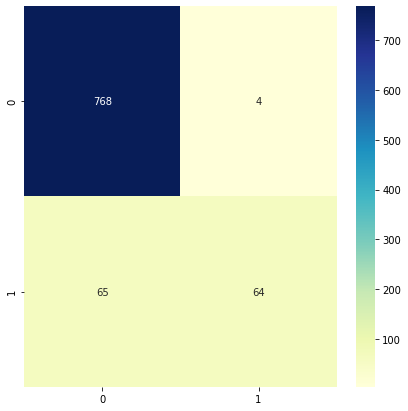

In [ ]:
# trainer.fit(model, train_loader, val_loader)
trainer.fit(model, train_loader, test_loader)

## Test

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loss:  1.6267756223678589
Accuracy: 0.9615100026130676
Precision: 0.9130434989929199
Recall: 0.6328766942024231
AUROC: 0.9291207790374756

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

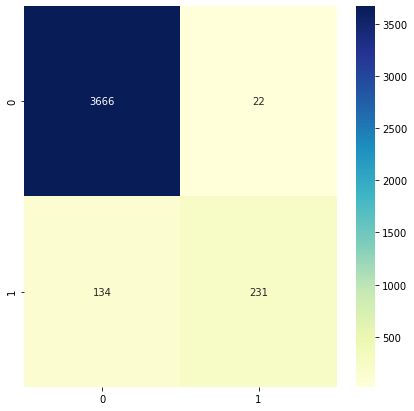

In [ ]:
trainer.test(test_dataloaders=val_loader)#, ckpt_path='latest.ckpt')

## Test on chunk voting

## Stop online logger

In [ ]:
exp_logger.experiment.stop()

# Mình không cài logger trong lightning module nhưng pl họ tự gọi log khi trainer có logger
# do đó cần xóa logger đi để tránh lỗi khi đã ngưng logger
trainer.logger=None

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 64 operations to synchronize with Neptune. Do not kill this process.


All 64 operations synced, thanks for waiting!


# Evaluating model

## Visualize misclassified samples

In [ ]:
raise NotImplementedError()

# Inference on private set for submission

## Dataloader for private test set

In [ ]:
private_set = AICOVIDDataset('f_pub_test', torch.nn.ModuleList([transform0]))

In [ ]:
private_loader = torch.utils.data.DataLoader(
    private_set,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Inference

### Segmentation and aggregate

In [ ]:
private_set = AICOVIDDataset('f_pub_test', torch.nn.ModuleList([transform0]), normalize=scaler, chunking=(400, 200))


> Archive download complete


  0%|          | 1/1233 [00:00<02:25,  8.45it/s]


> Extract complete


  3%|▎         | 35/1233 [00:00<00:03, 344.66it/s]


> File processing complete

> Start normalizing data


100%|██████████| 1233/1233 [00:27<00:00, 44.29it/s]



> Normalizing data complete


In [ ]:
private_loader = torch.utils.data.DataLoader(
    private_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
preds = trainer.predict(dataloaders=private_loader)
preds = torch.cat(preds)
preds = preds.cpu().numpy()
preds

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([3.6359e-06, 1.3769e-04, 1.0156e-01, ..., 5.0232e-02, 9.8407e-05,
       1.8179e-05], dtype=float16)

In [ ]:
tmp_df = pd.DataFrame({'segment': private_set.idxs,
                       'assessment_result': preds})
preds = tmp_df.groupby(['segment']).max()['assessment_result']

### On raw

In [ ]:
private_set = AICOVIDDataset(final_test_meta, torch.nn.ModuleList([transform0]), normalize=scaler)

In [ ]:
private_loader = torch.utils.data.DataLoader(
    private_set,
    collate_fn=collate_pad_seq_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
preds = trainer.predict(dataloaders=private_loader)
preds = torch.cat(preds)
preds = preds.cpu().numpy()
preds

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([6.32742594e-05, 5.76850789e-10, 1.11760864e-14, ...,
       1.06937587e-02, 5.90009060e-29, 1.49623702e-09], dtype=float32)

# Lưu kết quả

In [ ]:
# Tải file ngay tại notebook
from google.colab import files

In [ ]:
#@markdown Lưu lại model lên Google Drive
if train_mode:
  os.system('mkdir trained_models')
  compressed_name = f'{zip_name}_model.zip'
  torch.save(model.state_dict(), './trained_models/model_weights.pth')
  
  os.system(f'zip -j ./{compressed_name} ./trained_models/*')
  drive.Upload(compressed_name, model_zoo)

In [ ]:
#@markdown Lưu lại public test submission lên Google Drive
submit_df = pd.DataFrame({'uuid': private_set.meta_df['uuid'],
                          'assessment_result': preds})
submit_df.to_csv('results.csv', index=False)

# Nén file
os.system(f'zip -j ./{zip_name}.zip ./results.csv')

drive.Upload(zip_name+'.zip', submission_folder)

files.download(zip_name+'.zip')

In [ ]:
#@markdown Lưu lại private test submission lên Google Drive
submit_df = pd.DataFrame({'uuid': private_test_meta['uuid'],
                          'assessment_result': preds})
submit_df.to_csv('results.csv', index=False)

# Nén file
os.system(f'zip -j ./{zip_name}_private_test.zip ./results.csv')

drive.Upload(zip_name+'_private_test.zip', submission_folder)

files.download(zip_name+'_private_test.zip')

In [ ]:
#@markdown Load model lưu sẵn
if not train_mode:
  drive.Download(f'{zip_name}_model.zip', model_zoo)
  os.system(f'unzip -o {zip_name}_model.zip')
  model.load_state_dict(torch.load('model_weights.pth'))